In [1]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import yaml

mnist = tf.keras.datasets.mnist

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load data from mnist into train set and test set
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
# Turn data into one dimensional array (for KMeans fitting)
train_features = np.array([np.concatenate(i) for i in x_train])

test_features = np.array([np.concatenate(i) for i in x_test])
test_set = np.hstack((test_features, np.resize(y_test, (test_features.shape[0], 1))))

# print(train_set[0])

In [4]:
n_clusters = len(set(y_train))
classes = [[] for i in range(n_clusters)]
for i in range(n_clusters):
    classes[i] = train_features[np.where(y_train == i)]

In [5]:
# test if classes are ok
# plt.imshow(np.resize(classes[6][6],(28,28)))

In [6]:
%%time
# Creates clusters in each class, reducing number of points of data set
for new_data_len in range(50, 160, 10):
    clustering = []
#     new_data_len = 40
    for item in classes:
        clustering.append(KMeans(n_clusters = new_data_len, random_state = 0).fit(item))

    with open(f'classes_{new_data_len}.yaml', 'w') as f:
            yaml.dump(clustering, f)

CPU times: user 1h 58min 17s, sys: 47min 52s, total: 2h 46min 9s
Wall time: 1h 32s


In [7]:
%%time
# Creates clusters in each class, reducing number of points of data set
for new_data_len in [500]:
    clustering = []
#     new_data_len = 40
    for item in classes:
        clustering.append(KMeans(n_clusters = new_data_len, random_state = 0).fit(item))

    with open(f'classes_{new_data_len}.yaml', 'w') as f:
            yaml.dump(clustering, f)

CPU times: user 44min 46s, sys: 12min 33s, total: 57min 19s
Wall time: 19min 5s


In [32]:
# test if new classes are ok
# plt.imshow(np.resize(new_x_train_set[99], (28,28)))

In [8]:
def calc_disp_matrix(dataset):
    x = dataset - calc_mean(dataset)
    return np.dot(x.T, x)

def calc_cov_matrix(dataset):
    n = len(dataset)
    return calc_disp_matrix(dataset)/(n-1)

def calc_mean(dataset):
    return np.mean(dataset, axis=0)

def log_discriminant(sample, class_mean, class_cov, class_prob):
    cov_inv = np.linalg.inv(class_cov)
    g = -0.5*np.dot(np.dot((sample - class_mean), cov_inv), (sample - class_mean).T) - 0.5*np.log(np.linalg.det(class_cov)) + np.log(class_prob)
    
    return g

def bayesian_classifier(training_set, sample):
    data = training_set[:, 0:-1]
    labels = training_set[:,-1]
    print(data)
    print(labels)
    
    classes = set([int(i) for i in labels])
    set_size = len(data)
    g = [[] for i in classes]
    
    for i in classes:
        p_priori = len(data[np.where(labels == i)])/set_size
        g[i] = log_discriminant(sample, calc_mean(data[np.where(labels == i)]), calc_cov_matrix(data[np.where(labels == i)]), p_priori)
#         print(f'g[{i}] = {g[i]}')
#         print(g[i])
    
    return np.argmax(np.array(g))

def most_common(lst):
    return max(set(lst), key=lst.count)

def knn(dataset, sample, k):
    #dataset: (attributes, class labels)
    data = dataset[:, 0:-1]
    labels = dataset[:, -1]
    test_sample = np.array(sample)
    
    total_dist = data - test_sample                          # numpy automatically creates a repeated array of test_sample
    norm = np.sum(total_dist*total_dist, axis=1)
    neighbors = list(zip(norm, labels))                      # create list of tuples (square of distance, label of class)
    neighbors = sorted(neighbors, key=lambda tup: tup[0])    # sort neighbors by distance
    closest_n = [atribute[1] for atribute in neighbors[:k]]
    return most_common(closest_n)

def evaluate_error(classifier, training, test, extrArgs = []):
    error_rate = 0
    
    for sample in test:
        if classifier == knn:
            n = classifier(training, sample[:-1], extrArgs[0])
        else:
            n = classifier(training, sample[:-1])
        error_rate += not(n == sample[-1])
        
    return error_rate/len(test)

def split_folds(dataset, k):
    data_cpy = dataset.copy()
    np.random.shuffle(data_cpy)            # desordena conjunto de dados
    folds = np.split(data_cpy, k)          # divide os grupos
    return folds

def kfolds(classifier, dataset, k, extrArgs = []):
    folds = split_folds(dataset, k)
    error_array = []

    for i, fold in enumerate(folds):
        folds_cpy = folds.copy()           # cria cópia dos grupos
        test = folds_cpy.pop(i)            # separa grupo i para teste
        training = np.vstack(folds_cpy)    # agrupa demais grupos para treinamento
        error_array = np.append(error_array, evaluate_error(classifier, training, test, extrArgs))
    
    return np.mean(error_array), np.std(error_array)

In [12]:
%%time
for new_data_len in range(50, 160, 10):
    print(f'K = {new_data_len}')
    new_x_train_set = []
    new_y_train_set = []
    i = 0

    with open(f'classes_{new_data_len}.yaml', 'r') as f:
        clustering = yaml.load(f)

    for c in clustering:
        new_x_train_set.append(c.cluster_centers_)
        new_y_train_set.append([i for x in range(len(c.cluster_centers_))])
        i += 1
#     plt.imshow(np.resize(new_x_train_set, (28, 28)))
    new_x_train_set = np.concatenate(new_x_train_set)
    new_y_train_set = np.concatenate(new_y_train_set)
#     print(len(new_x_train_set))


    training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
    # training_set = np.hstack((train_set, np.resize(y_train, (x_train.shape[0], 1))))
    
#     print(f'K={new_data_len}, {evaluate_error(knn, training_set, test_set, [5])}')
#     print(f'K = {new_data_len}, k = 5, KNN error rate {kfolds(knn, training_set, 10, [5])}')
    for k in range(1,12):
        print(f'\tk = {k}, KNN error rate {kfolds(knn, training_set, 10, [k])}')
    print()

K = 50


NameError: name 'kfolds' is not defined

In [14]:
%%time
for new_data_len in range(50, 160, 10):
    new_x_train_set = []
    new_y_train_set = []
    i = 0

    with open(f'classes_{new_data_len}.yaml', 'r') as f:
        clustering = yaml.load(f)

    for c in clustering:
        new_x_train_set.append(c.cluster_centers_)
        new_y_train_set.append([i for x in range(len(c.cluster_centers_))])
        i += 1

    new_x_train_set = np.concatenate(new_x_train_set)
    new_y_train_set = np.concatenate(new_y_train_set)
#     print(len(new_x_train_set))

    training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
w
    print(f'K={new_data_len}, {evaluate_error(knn, training_set, test_set, [5])}')

K=50, 0.0679
K=60, 0.0601
K=70, 0.0566
K=80, 0.0523
K=90, 0.0523
K=100, 0.0495
K=110, 0.05
K=120, 0.0485
K=130, 0.0497
K=140, 0.0433
K=150, 0.0437
CPU times: user 6min 41s, sys: 5min 33s, total: 12min 14s
Wall time: 12min 15s


### usar erro médio exponencial

ei+1 = (1-y)eatual + yei

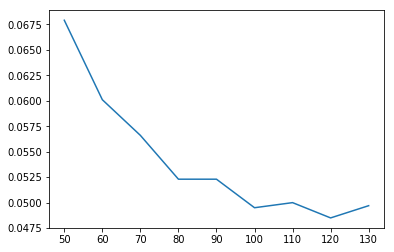

In [18]:
x = [(50, 0.0679),
(60, 0.0601),
(70, 0.0566),
(80, 0.0523),
(90, 0.0523),
(100, 0.0495),
(110, 0.05),
(120, 0.0485),
(130, 0.0497)]

plt.plot([a[0] for a in x], [a[1] for a in x])

In [9]:
%%time
for new_data_len in [500]:
    new_x_train_set = []
    new_y_train_set = []
    i = 0

    with open(f'classes_{new_data_len}.yaml', 'r') as f:
        clustering = yaml.load(f)

    for c in clustering:
        new_x_train_set.append(c.cluster_centers_)
        new_y_train_set.append([i for x in range(len(c.cluster_centers_))])
        i += 1

    new_x_train_set = np.concatenate(new_x_train_set)
    new_y_train_set = np.concatenate(new_y_train_set)
#     print(len(new_x_train_set))

    training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
    
    print(f'K={new_data_len}, {evaluate_error(knn, training_set, test_set, [5])}')

K=500, 0.0361
CPU times: user 3min 12s, sys: 2min 46s, total: 5min 59s
Wall time: 5min 59s


In [10]:
%%time
for new_data_len in [100]:
    new_x_train_set = []
    new_y_train_set = []
    i = 0

    with open(f'classes_{new_data_len}.yaml', 'r') as f:
        clustering = yaml.load(f)

    for c in clustering:
        new_x_train_set.append(c.cluster_centers_)
        new_y_train_set.append([i for x in range(len(c.cluster_centers_))])
        i += 1

    new_x_train_set = np.concatenate(new_x_train_set)
    new_y_train_set = np.concatenate(new_y_train_set)
#     print(len(new_x_train_set))

    training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
    
    print(f'K={new_data_len}, {evaluate_error(knn, training_set, test_set, [5])}')

K=100, 0.0495
CPU times: user 40.5 s, sys: 41.2 ms, total: 40.6 s
Wall time: 40.7 s


In [62]:
%%time
training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
# training_set = np.hstack((train_set, np.resize(y_train, (x_train.shape[0], 1))))

for k in range(1,12):
    print(f'k = {k}, KNN error rate {kfolds(knn, training_set, 10, [k])}')
    
# k = 5 apresentou os melhores resultados

k = 1, KNN error rate (0.1, 0.035355339059327376)
k = 2, KNN error rate (0.12250000000000001, 0.05857687256929991)
k = 3, KNN error rate (0.06, 0.032015621187164243)
k = 4, KNN error rate (0.05750000000000001, 0.0225)
k = 5, KNN error rate (0.042499999999999996, 0.03363406011768428)
k = 6, KNN error rate (0.05750000000000001, 0.0317214438511238)
k = 7, KNN error rate (0.04, 0.03)
k = 8, KNN error rate (0.042499999999999996, 0.0275)
k = 9, KNN error rate (0.0475, 0.02839454172900137)
k = 10, KNN error rate (0.0475, 0.0343693177121688)
k = 11, KNN error rate (0.045000000000000005, 0.029154759474226504)
CPU times: user 4.27 s, sys: 5.66 ms, total: 4.28 s
Wall time: 4.27 s


In [208]:
%%timeit
training_set = np.hstack((new_x_train_set, np.resize(new_y_train_set, (new_x_train_set.shape[0], 1))))
correct = 0

for i, sample in enumerate(x_test):
    sample = np.concatenate(sample)
    predicted = knn(training_set, sample, 4)
    if predicted == y_test[i]:
        correct += 1
        
print(f'success rate: {100*correct/len(x_test)}')

success rate: 94.74


In [17]:
x = [i > 50 for i in train_set[0]]
x = [256 if i else 0 for i in x]

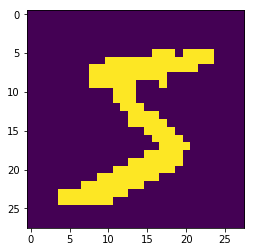

In [18]:
plt.imshow(np.resize(x, (28, 28)))